Below, we show how to fully initialize a simulation.

Boundary injection CVS file successfully loaded for NB_LD_EV. The time bin is 1.00 min(s).
Boundary injection CVS file successfully loaded for NB_LD_ICE. The time bin is 1.00 min(s).
Minimum road resolution used. There are 53 road segments, each of length 1.89 km.
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
6.415290187701467 7.472946645224939 13.888236832926406 13.88823683292641 0.461922579869319 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
10.2805550593965 12.148947425779651 22.42950248517615 22.429502485176148 0.4583496698685585 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
11.9848669094189 13.94655449317964 25.931421402598538 25.931421402598538 0.46217547134604503 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
12.76762984441129 14.360280521639897 27.127910366051186 27.1279103660

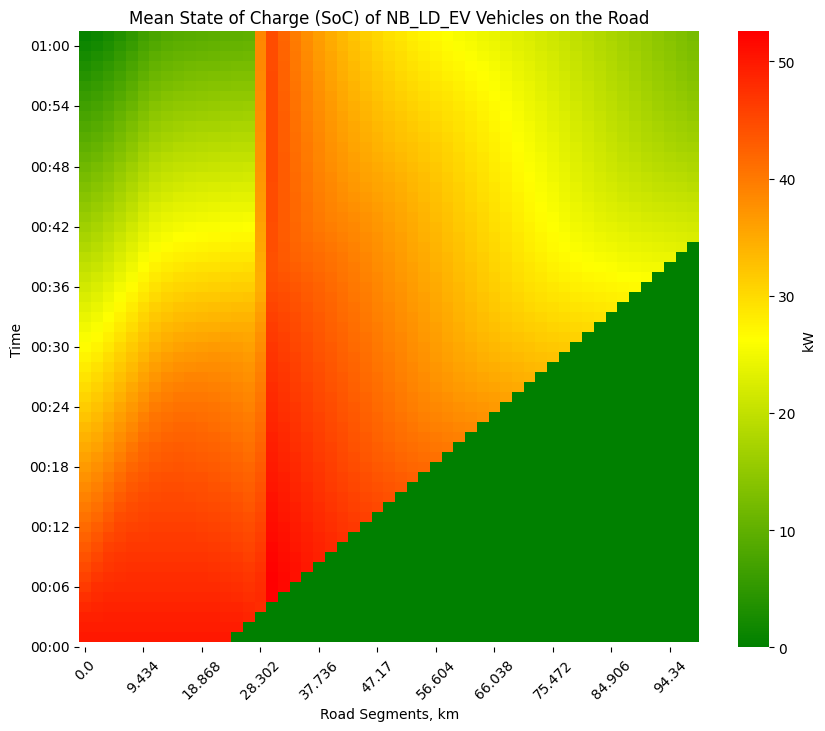

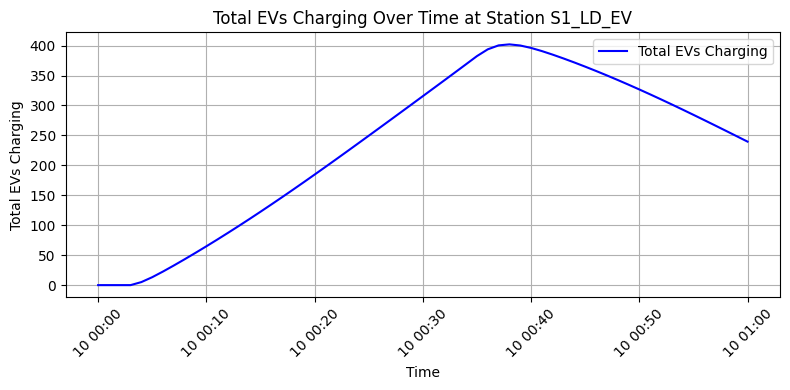

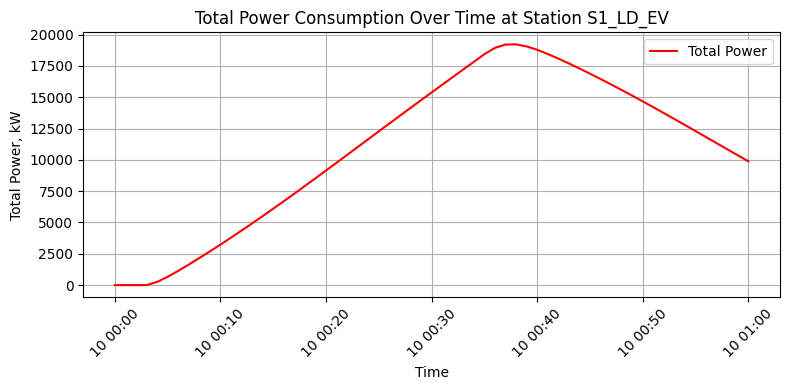

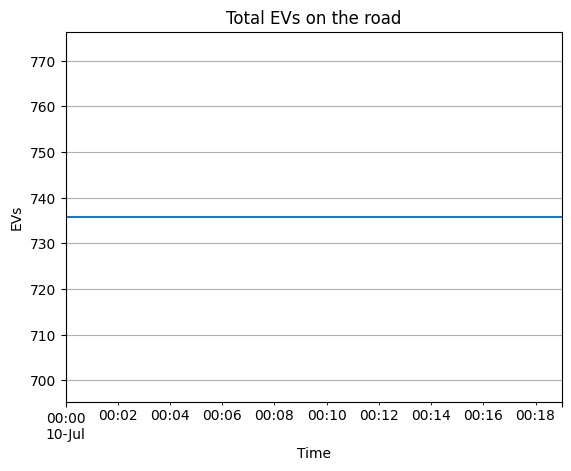

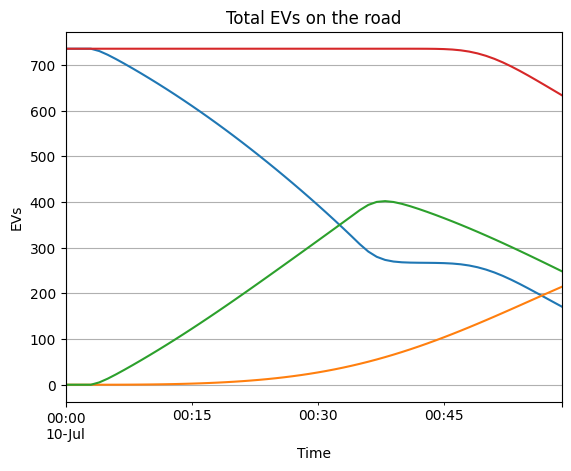

In [9]:
# RECOMMENDED TO RESTART KERNEL EACH TIME
import CTEC

# Initialize the traffic behaviour for all vehicles on the road.
traffic = CTEC.trafficBehaviour(avg_vehicle_length=4.5,
                                avg_vehicle_buffer=3.6,
                                freeflow_speed=90)

# Initialize the type of vehicles to be added to the road
emax = 75
NB_LD_EV = CTEC.vehicleType(battery_capacity=emax,
                         discharge_rate_freeflow=-50 ,#-18,
                         discharge_rate_jam=-5,
                         vehicleType_ID='NB_LD_EV') #-1)

NB_LD_ICE = CTEC.vehicleType(vehicleType_ID = 'NB_LD_ICE')

# Initialize an fast-charging service station
S1_LD_EV = CTEC.stationType(vehicleType=NB_LD_EV,
                            off_ramp_location=30, # km
                            on_ramp_location=40, # km
                            max_charging_rate=50, # kW
                            stationType_ID='S1_LD_EV')

# Initialize the road
x0 = 0; xf = 100
road = CTEC.roadScenario(trafficBehaviour=traffic,
                         road_start=x0,
                         road_end=xf)

road.load_vehicleType(NB_LD_EV, boundary_injection_path='empty.csv')
road.load_vehicleType(vehicleType=NB_LD_ICE, boundary_injection_path='empty.csv')
road.load_stationType(S1_LD_EV)

road.initialize_with_loaded_data()

# ADD IN TEST DISTRIBUTIONS ON THE ROAD
import numpy as np
start_index = road.road_cells // 4  # Start of the second quarter
end_index = road.road_cells // 2  # End of the second quarter
test = np.zeros(road.road_cells)
test[:start_index] = 1
road.vehicleType_dict['NB_LD_ICE']['road_density'] = test*20 #np.zeros(self.road_cells)
road.vehicleType_dict['NB_LD_EV']['road_density'] = test*30 #np.zeros(self.road_cells)
road.vehicleType_dict['NB_LD_EV']['road_SoC'] = test*50 #np.zeros(self.road_cells)

CTECsim = CTEC.simulator(roadScenario=road)

CTECsim.simulate()

import pandas as pd
# Assuming df is your DataFrame
df = CTECsim.results_dict['stationType_results']['S1_LD_EV']['total_power']

# Ensure the index is in datetime format if it isn't already
df.index = pd.to_datetime(df.index)

# Calculate the time difference between each measurement in hours
# If your data is not uniformly spaced, this step ensures accuracy
time_diffs = df.index.to_series().diff().dt.total_seconds().div(3600)[1:]  # Convert to hours, ignore the first NaN

# Multiply each power value (assuming kW) by the time difference to get energy (kWh)
# We use [:-1] to align the time diffs with the power measurements; the last power value doesn't have a subsequent time diff
energy = df.iloc[:-1].multiply(time_diffs.values, axis=0)

# Sum the energy values to get total energy consumed
total_energy = energy.sum(axis=0) / 1000  # Convert to MWh if needed

print(total_energy)

'''CTECsim.plot(category='aggregate_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_ICE', plotType='road_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='road_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='road_energy_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='road_SoC')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV_from_S1_LD_EV', plotType='road_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV_from_S1_LD_EV', plotType='road_energy_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV_from_S1_LD_EV', plotType='road_SoC')'''
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='road_SoC')
CTECsim.plot(category='stationType_results', instance='S1_LD_EV', plotType='total_EVs_charging', width=8, height=4)
CTECsim.plot(category='stationType_results', instance='S1_LD_EV', plotType='total_power', width=8, height=4)

import pandas as pd
import matplotlib.pyplot as plt

x=((CTECsim.results_dict['vehicleType_results']['NB_LD_EV']['road_density'].sum(axis=1) + 
   CTECsim.results_dict['vehicleType_results']['NB_LD_EV_from_S1_LD_EV']['road_density'].sum(axis=1))*road.road_resolution +
   CTECsim.results_dict['stationType_results']['S1_LD_EV']['SoC_vehicles'].sum(axis=1))

# Plotting
x[:20].plot()

# Optional: Enhancements for better visualization
plt.title('Total EVs on the road')
plt.xlabel('Time')
plt.ylabel('EVs')
plt.grid(True)

# Display the plot
plt.show()

view_offset = 0
slice_end = -1
x=((CTECsim.results_dict['vehicleType_results']['NB_LD_EV']['road_density'].sum(axis=1) + 
   CTECsim.results_dict['vehicleType_results']['NB_LD_EV_from_S1_LD_EV']['road_density'].sum(axis=1))*road.road_resolution +
   CTECsim.results_dict['stationType_results']['S1_LD_EV']['SoC_vehicles'].sum(axis=1))

# Plotting
(CTECsim.results_dict['vehicleType_results']['NB_LD_EV']['road_density'].sum(axis=1)*road.road_resolution-view_offset)[:slice_end].plot()
(CTECsim.results_dict['vehicleType_results']['NB_LD_EV_from_S1_LD_EV']['road_density'].sum(axis=1)*road.road_resolution)[:slice_end].plot()
CTECsim.results_dict['stationType_results']['S1_LD_EV']['SoC_vehicles'].sum(axis=1)[:slice_end].plot()

(x[:slice_end]-view_offset).plot()

# Optional: Enhancements for better visualization
plt.title('Total EVs on the road')
plt.xlabel('Time')
plt.ylabel('EVs')
plt.grid(True)

# Display the plot
plt.show()

In [3]:
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='wrong type')

KeyError: "Invalid plotType: wrong type. Available options are: ['road_density', 'road_SoC', 'road_energy_density']"

Code to describe the creation of the splitting coefficient, beta.

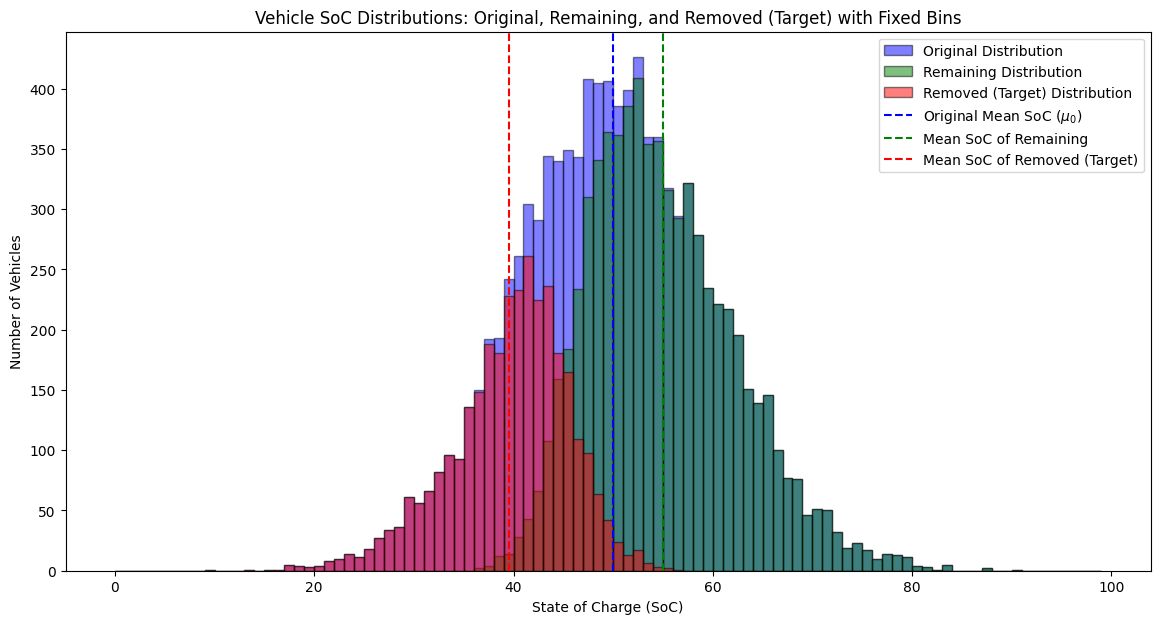

Original mean SoC: 50
Mean SoC of remaining vehicles: 55.01
Mean SoC of removed (target) vehicles: 39.59


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_vehicle_soc_distribution(num_vehicles, mu_0, sigma):
    """Generates a normal distribution of vehicle SoC values."""
    return np.random.normal(mu_0, sigma, num_vehicles)

def removal_probability(x, mu_c, k):
    """Calculates the probability of removing a vehicle based on its SoC, corrected to remove lower SoCs."""
    return 1 / (1 + np.exp(k * (x - mu_c)))

def conditional_removal(soc_values, mu_c, k):
    """Conditionally removes vehicles based on their SoC, returning the removed and remaining SoCs."""
    removal_probs = removal_probability(soc_values, mu_c, k)
    removed = np.random.rand(len(soc_values)) < removal_probs
    remaining_soc_values = soc_values[~removed]
    removed_soc_values = soc_values[removed]
    return remaining_soc_values, removed_soc_values

def plot_distributions_with_fixed_bins(original_soc, remaining_soc, removed_soc, mu_0, bins):
    """Plots the original, remaining, and removed vehicle SoC distributions with specified bins."""
    plt.figure(figsize=(14, 7))
    plt.hist(original_soc, bins=bins, alpha=0.5, label='Original Distribution', color='blue', edgecolor='black')
    plt.hist(remaining_soc, bins=bins, alpha=0.5, label='Remaining Distribution', color='green', edgecolor='black')
    plt.hist(removed_soc, bins=bins, alpha=0.5, label='Removed (Target) Distribution', color='red', edgecolor='black')
    plt.axvline(mu_0, color='blue', linestyle='--', label='Original Mean SoC ($\mu_0$)')
    plt.axvline(np.mean(remaining_soc), color='green', linestyle='--', label='Mean SoC of Remaining')
    plt.axvline(np.mean(removed_soc), color='red', linestyle='--', label='Mean SoC of Removed (Target)')
    plt.title('Vehicle SoC Distributions: Original, Remaining, and Removed (Target) with Fixed Bins')
    plt.xlabel('State of Charge (SoC)')
    plt.ylabel('Number of Vehicles')
    plt.legend()
    plt.show()

# Parameters
num_vehicles = 10000
mu_0 = 50  # Mean State of Charge
sigma = 10  # Standard deviation of SoC
mu_c = 45  # Cutoff State of Charge for conditional removal
k = 0.5  # Steepness parameter for the removal probability function
bin_edges = np.arange(0, 100, 1)  # Bins from 0 to 99 with a width of 1

# Generate the original distribution of vehicle SoC values
original_soc_values = generate_vehicle_soc_distribution(num_vehicles, mu_0, sigma)

# Apply conditional removal to separate the SoC values into remaining and removed (target) sets
remaining_soc_values, removed_soc_values = conditional_removal(original_soc_values, mu_c, k)

# Plot the distributions with the specified bins
plot_distributions_with_fixed_bins(original_soc_values, remaining_soc_values, removed_soc_values, mu_0, bin_edges)

# Display means for clarity
print(f"Original mean SoC: {mu_0}")
print(f"Mean SoC of remaining vehicles: {np.mean(remaining_soc_values):.2f}")
print(f"Mean SoC of removed (target) vehicles: {np.mean(removed_soc_values):.2f}")

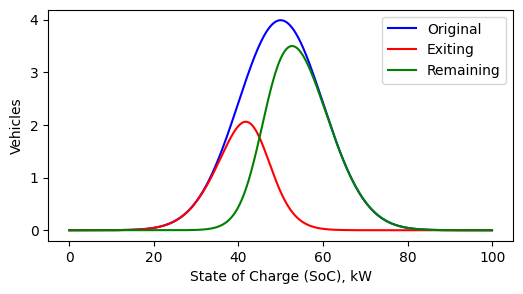

Skewness of Original Distribution: 1.1093658345458381
Kurtosis of Original Distribution: -0.31072287766129314
Skewness of Removed Distribution: 1.7884502033154055
Kurtosis of Removed Distribution: 1.7996532299873769
Skewness of Remaining Distribution: 1.520720276271305
Kurtosis of Remaining Distribution: 0.8174433289353877

 100 99.9999426758923 33.30263243534587 66.69731024054644


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

def generate_vehicle_soc_density(mu_0, sigma, vehicle_count, bins):
    """Generates a continuous density function of vehicle SoC values."""
    bin_centers = (bins[:-1] + bins[1:]) / 2
    density = norm.pdf(bin_centers, mu_0, sigma)
    # Normalize to make the total area under the curve correspond to vehicle_count
    density *= vehicle_count
    return density

def calculate_removal_density(density, mu_c, k, bins):
    """Calculates the density of vehicles to be removed based on a continuous model."""
    bin_centers = (bins[:-1] + bins[1:]) / 2
    removal_probs = 1 / (1 + np.exp(k * (bin_centers - mu_c)))
    removal_density = density * removal_probs  # Expected density of removed vehicles
    remaining_density = density - removal_density  # Remaining density after removal
    return remaining_density, removal_density

def plot_continuous_distributions(bins, original_density, remaining_density, removed_density):
    """Plots the original, remaining, and removed vehicle SoC densities."""
    plt.figure(figsize=(6, 3))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, original_density, label='Original', color='blue')
    plt.plot(bin_centers, removed_density, label='Exiting', color='red')
    plt.plot(bin_centers, remaining_density, label='Remaining', color='green')
    #plt.title('Vehicle SoC Distributions: Original, Remaining, and Removed')
    plt.xlabel('State of Charge (SoC), kW')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.show()

# Parameters for a more continuous approach
mu_0 = 50  # Mean State of Charge
sigma = 10  # Standard deviation of SoC
mu_c = 45  # Cutoff State of Charge for conditional removal
veh_count = 100
k = 0.3  # Steepness parameter for the removal probability function
bins = np.linspace(0, 100, 1000)  # A finer binning for a more continuous representation

# Generate the original density function of vehicle SoC values
original_density = generate_vehicle_soc_density(mu_0, sigma, veh_count, bins)

# Calculate the densities for remaining and removed vehicles
remaining_density, removed_density = calculate_removal_density(original_density, mu_c, k, bins)

# Plot the continuous distributions
plot_continuous_distributions(bins, original_density, remaining_density, removed_density)

# Checking if distributions are Gaussian
from scipy.stats import norm, skew, kurtosis
print("Skewness of Original Distribution:", skew(original_density))
print("Kurtosis of Original Distribution:", kurtosis(original_density))
print("Skewness of Removed Distribution:", skew(removed_density))
print("Kurtosis of Removed Distribution:", kurtosis(removed_density))
print("Skewness of Remaining Distribution:", skew(remaining_density))
print("Kurtosis of Remaining Distribution:", kurtosis(remaining_density))

# Calculate the bin width
bin_width = bins[1] - bins[0]

print('\n', veh_count, 
      np.sum(original_density * bin_width),
      np.sum(removed_density * bin_width),
      np.sum(remaining_density * bin_width))

In [ ]:
remaining_density

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

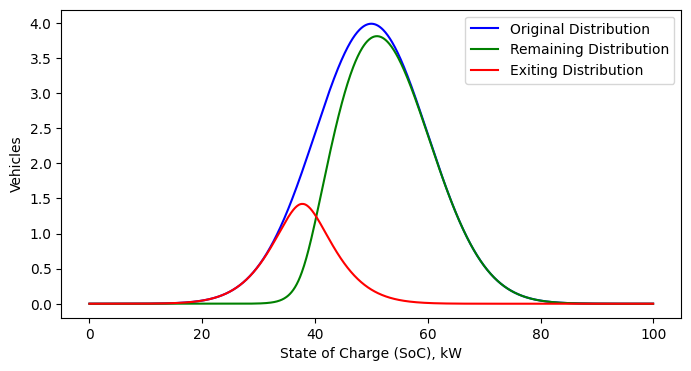

Skewness of Removed Distribution: 1.9742286256083867
Kurtosis of Removed Distribution: 2.6502738512421624
Skewness of Remaining Distribution: 1.3684139281744727
Kurtosis of Remaining Distribution: 0.3067061711397785


In [ ]:
# Re-import necessary libraries after reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, kurtosis

def generate_vehicle_soc_density(mu_0, sigma, vehicle_count, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    density = norm.pdf(bin_centers, mu_0, sigma)
    density *= vehicle_count # Normalize to total vehicle count
    return density

def calculate_removal_density_with_symmetry(density, mu_c, k, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    removal_probs = 1 / (1 + np.exp(k * (bin_centers - mu_c)))
    removal_density = density * removal_probs
    
    # Find the index of the maximum value in the removal density
    max_index = np.argmax(removal_density)
    center_point = bin_centers[max_index]
    
    # Mirror the lower half onto the upper half centered around the maximum value
    for i in range(len(bin_centers)):
        if bin_centers[i] > center_point:
            mirrored_index = np.argmin(np.abs(bin_centers - (2 * center_point - bin_centers[i])))
            removal_density[i] = removal_density[mirrored_index]
    
    remaining_density = density - removal_density
    return remaining_density, removal_density, center_point

def plot_continuous_distributions(bins, original_density, remaining_density, removed_density):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.figure(figsize=(8, 4))
    plt.plot(bin_centers, original_density, label='Original Distribution', color='blue')
    plt.plot(bin_centers, remaining_density, label='Remaining Distribution', color='green')
    plt.plot(bin_centers, removed_density, label='Exiting Distribution', color='red')
    #plt.title('Vehicle SoC Distributions: Original, Remaining, and Removed')
    plt.xlabel('State of Charge (SoC), kW')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.show()

# Parameters for a more continuous approach
mu_0, sigma, vehicle_count = 50, 10, 100
mu_c, k = 40, 0.5
bins = np.linspace(0, 100, 1000)

# Generate the original density function of vehicle SoC values
original_density = generate_vehicle_soc_density(mu_0, sigma, vehicle_count, bins)

# Calculate the densities for remaining and removed vehicles with symmetry
remaining_density, removed_density, center_point = calculate_removal_density_with_symmetry(original_density, mu_c, k, bins)

# Plot the continuous distributions
plot_continuous_distributions(bins, original_density, remaining_density, removed_density)

# Checking if distributions are Gaussian
print("Skewness of Removed Distribution:", skew(removed_density))
print("Kurtosis of Removed Distribution:", kurtosis(removed_density))
print("Skewness of Remaining Distribution:", skew(remaining_density))
print("Kurtosis of Remaining Distribution:", kurtosis(remaining_density))


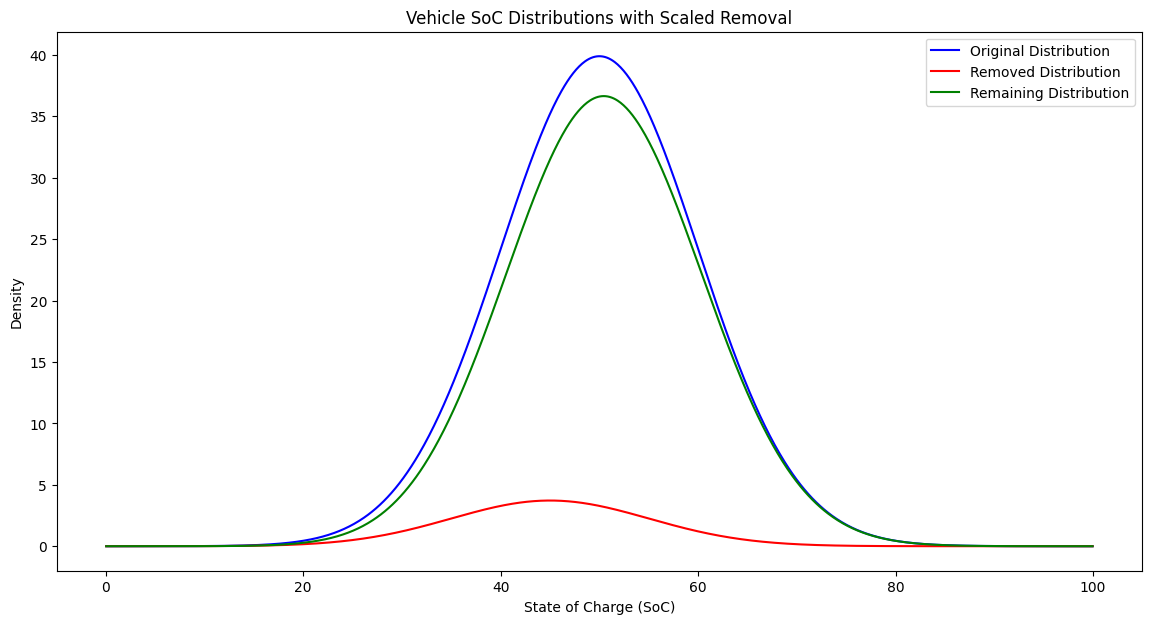

Scale factor applied to removed distribution: 93.24736979957999


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def scale_removed_distribution(mu_0, sigma, mu_c, vehicle_count, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    original_density = norm.pdf(bin_centers, mu_0, sigma)
    original_density *= vehicle_count / original_density.sum()  # Scale to total vehicle count
    
    removed_density_unscaled = norm.pdf(bin_centers, mu_c, sigma)
    # Scale the removed density to maximize height without exceeding the original density
    scale_factor = np.min(original_density[bin_centers <= mu_c] / removed_density_unscaled[bin_centers <= mu_c])
    removed_density = removed_density_unscaled * scale_factor
    remaining_density = np.maximum(original_density - removed_density, 0)
    
    return bin_centers, original_density, removed_density, remaining_density, scale_factor

# Parameters
mu_0, sigma, mu_c, vehicle_count = 50, 10, 45, 10000
bins = np.linspace(0, 100, 1001)

bin_centers, original_density, removed_density, remaining_density, scale_factor = scale_removed_distribution(mu_0, sigma, mu_c, vehicle_count, bins)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(bin_centers, original_density, label='Original Distribution', color='blue')
plt.plot(bin_centers, removed_density, label='Removed Distribution', color='red')
plt.plot(bin_centers, remaining_density, label='Remaining Distribution', color='green')
plt.title('Vehicle SoC Distributions with Scaled Removal')
plt.xlabel('State of Charge (SoC)')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"Scale factor applied to removed distribution: {scale_factor}")


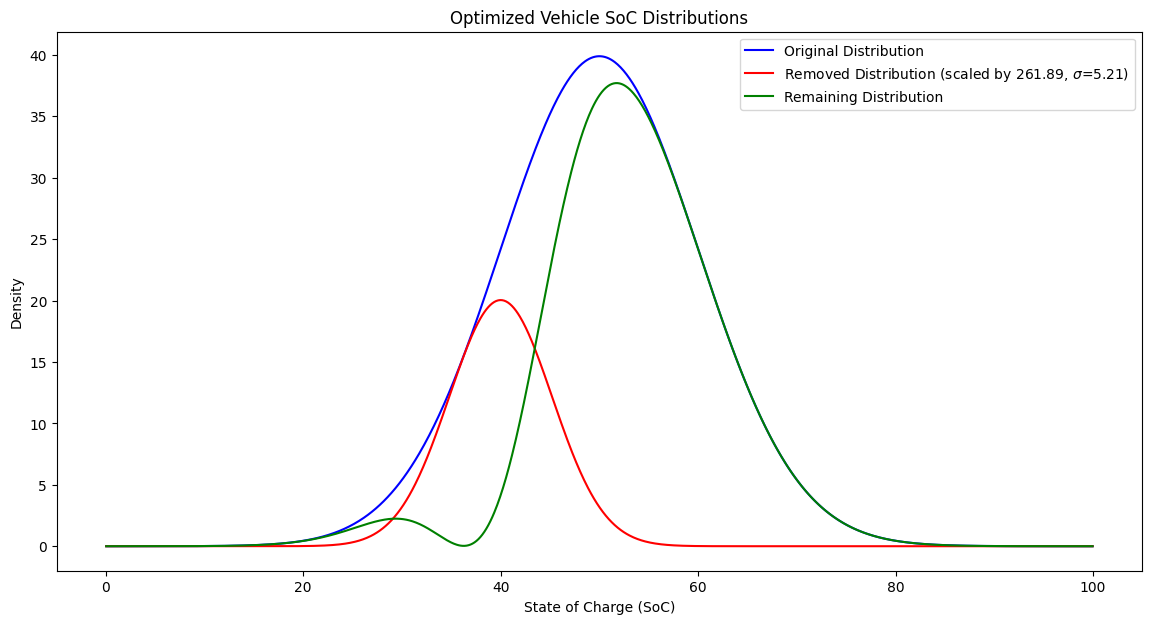

In [ ]:
def optimize_removed_distribution(mu_0, sigma, mu_c, vehicle_count, bins):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    original_density = generate_vehicle_soc_density(mu_0, sigma, vehicle_count, bins)

    # Start with sigma_removed equal to the original sigma and adjust
    sigma_removed = sigma/3
    scale_factor = 1
    optimal_scale = 0

    # Iteratively adjust sigma_removed and find the optimal scale factor
    for _ in np.linspace(sigma, 0, num=500):  # Decrease sigma_removed
        sigma_removed += 0.02  # Small step to decrease sigma_removed
        removed_density_trial = norm.pdf(bin_centers, mu_c, sigma_removed)
        scale_factor = np.min(original_density / removed_density_trial)
        
        # Check if the scaled, removed density exceeds the original density
        if not np.any((removed_density_trial * scale_factor) > original_density):
            optimal_scale = scale_factor  # Update the optimal scale if condition is met
        else:
            break  # Stop if the removed density exceeds the original at any point

    # Calculate the final removed and remaining densities using the optimal sigma_removed and scale factor
    removed_density = norm.pdf(bin_centers, mu_c, sigma_removed) * optimal_scale
    remaining_density = np.maximum(original_density - removed_density, 0)
    
    return bin_centers, original_density, removed_density, remaining_density, sigma_removed, optimal_scale

# Parameters
mu_0, sigma, mu_c, vehicle_count = 50, 10, 40, 10000
bins = np.linspace(0, 100, 1001)

# Optimize the removed distribution
bin_centers, original_density, removed_density, remaining_density, sigma_removed, optimal_scale = optimize_removed_distribution(mu_0, sigma, mu_c, vehicle_count, bins)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(bin_centers, original_density, label='Original Distribution', color='blue')
plt.plot(bin_centers, removed_density, label=f'Removed Distribution (scaled by {optimal_scale:.2f}, $\sigma$={sigma_removed:.2f})', color='red')
plt.plot(bin_centers, remaining_density, label='Remaining Distribution', color='green')
plt.title('Optimized Vehicle SoC Distributions')
plt.xlabel('State of Charge (SoC)')
plt.ylabel('Density')
plt.legend()
plt.show()


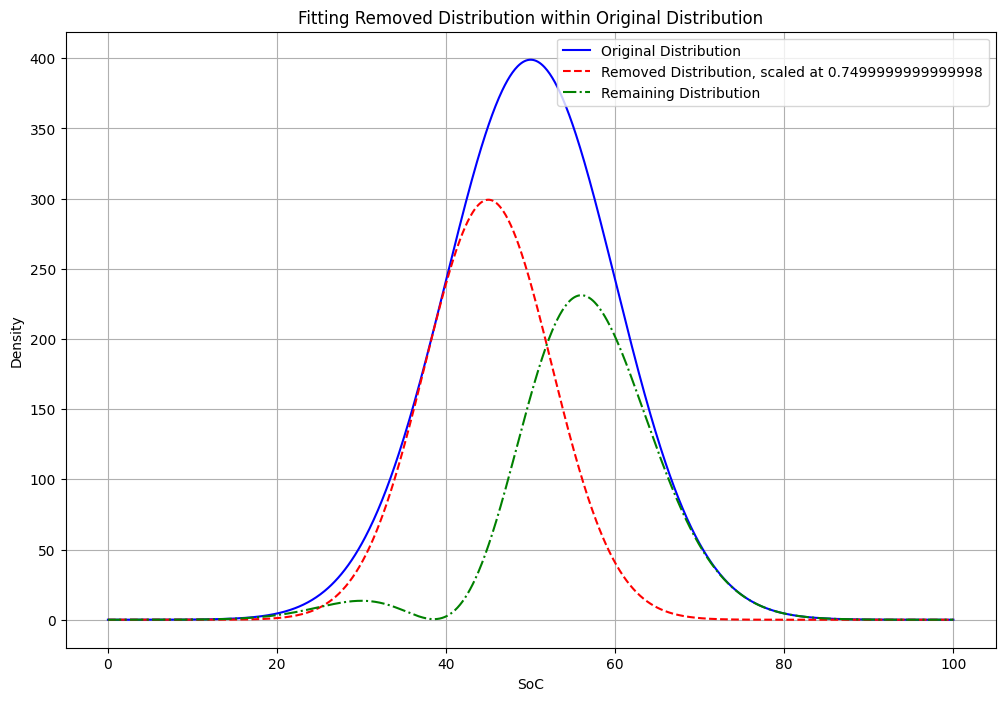

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_gaussian(mu, sigma, bins):
    """Generate Gaussian distribution values."""
    return norm.pdf(bins, mu, sigma)



# 1. Generate the original distribution
mu_0 = 50
sigma_0 = 10
fwhm = np.sqrt(8 * np.log(2))
vehicle_count = 10000
bins = np.linspace(0, 100, 1000)
original_distribution = norm.pdf(bins, mu_0, sigma_0) * vehicle_count

# Initialize removed distribution to match the original, but centered at mu_c
mu_c = 45
removed_distribution = norm.pdf(bins, mu_c, sigma_0) * vehicle_count

# Iterate to fit the removed distribution within the original
scale_vehicles = 1.0
scale_sigma = scale_vehicles
plt.figure(figsize=(12, 8))
plt.plot(bins, original_distribution, label='Original Distribution', color='blue')
while np.any(removed_distribution > original_distribution):
    scale_vehicles -= 0.01  # Decrease scale factor to reduce the height of the distribution
    scale_sigma = scale_vehicles
    if scale_factor < 0: break
    removed_distribution = generate_gaussian(mu_c, sigma * scale_sigma, bins) * vehicle_count * scale_vehicles**2

while np.any(removed_distribution > original_distribution):
    scale_sigma += 0.01
    removed_distribution = generate_gaussian(mu_c, sigma * scale_sigma, bins) * vehicle_count * scale_vehicles**2
    
# Calculate the remaining distribution
remaining_distribution = np.maximum(original_distribution - removed_distribution, 0)

# Plotting
plt.plot(bins, removed_distribution, label=f'Removed Distribution, scaled at {scale_factor}', color='red', linestyle='--')
plt.plot(bins, remaining_distribution, label='Remaining Distribution', color='green', linestyle='-.')
plt.title('Fitting Removed Distribution within Original Distribution')
plt.xlabel('SoC')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

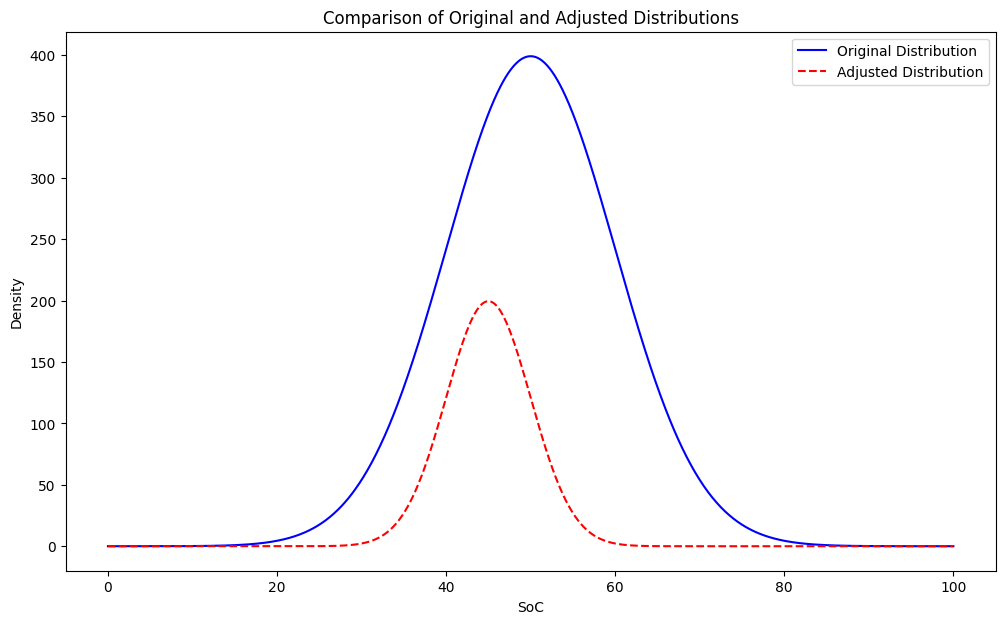

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for demonstration
mu_0 = 50  # Original mean
sigma_0 = 10  # Original standard deviation
vehicle_count = 10000  # Scale factor representing the total count
mu_c = 45  # New mean for the adjusted distribution

# Bins for plotting
bins = np.linspace(0, 100, 1000)

# Generate the original distribution for visualization
original_distribution = norm.pdf(bins, mu_0, sigma_0) * vehicle_count

# Generate the adjusted distribution
# Halving sigma for half the width
sigma_adjusted = sigma_0 / 2
# Adjusting the scale factor for the height within the PDF creation
adjusted_distribution = norm.pdf(bins, mu_c, sigma_adjusted) * (vehicle_count / 2**2)

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(bins, original_distribution, label='Original Distribution', color='blue')
plt.plot(bins, adjusted_distribution, label='Adjusted Distribution', color='red', linestyle='--')
plt.title('Comparison of Original and Adjusted Distributions')
plt.xlabel('SoC')
plt.ylabel('Density')
plt.legend()
plt.show()


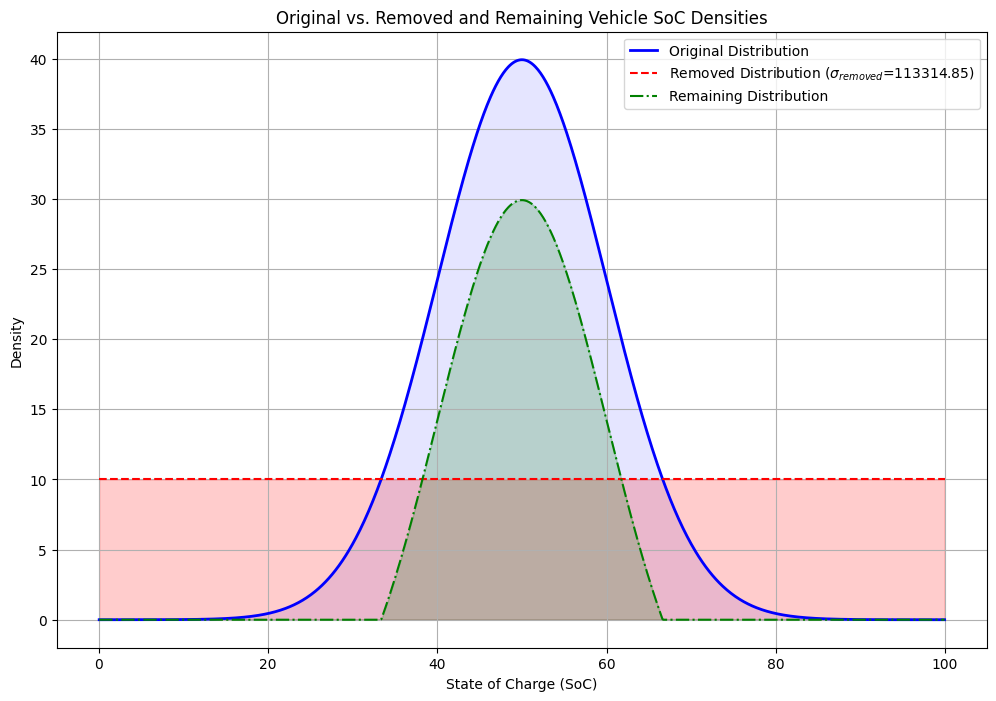

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_vehicle_soc_density(mu, sigma, vehicle_count, bins):
    """Generates a continuous density function of vehicle SoC values."""
    bin_centers = (bins[:-1] + bins[1:]) / 2
    density = norm.pdf(bin_centers, mu, sigma)
    density *= vehicle_count / density.sum()  # Normalize to total vehicle count
    return density, bin_centers

def calculate_sigma_removed_directly(mu_0, sigma, mu_c, vehicle_count, original_density_at_mu_c):
    """Calculates sigma for the removed distribution to maintain shape and fit within the original."""
    A = vehicle_count  # Assuming the scaling factor represents the total vehicle count
    sigma_removed = A / (original_density_at_mu_c * np.sqrt(2 * np.pi))
    return sigma_removed

# Parameters for the original distribution
mu_0, sigma, vehicle_count = 50, 10, 10000
mu_c = 45  # Center for the removed distribution
bins = np.linspace(0, 100, 1000)  # Define the range and resolution of SoC values

# Generate the original distribution density
original_density, bin_centers = generate_vehicle_soc_density(mu_0, sigma, vehicle_count, bins)

# Get the density of the original distribution at mu_c to use in calculating sigma_removed
original_density_at_mu_c = norm.pdf(mu_c, mu_0, sigma)

# Calculate sigma_removed directly
sigma_removed = calculate_sigma_removed_directly(mu_0, sigma, mu_c, vehicle_count, original_density_at_mu_c)

# Generate the removed distribution density with the new sigma_removed
removed_density, _ = generate_vehicle_soc_density(mu_c, sigma_removed, vehicle_count, bins)

# Calculate the remaining distribution by ensuring it doesn't go negative
remaining_density = np.maximum(original_density - removed_density, 0)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(bin_centers, original_density, label='Original Distribution', color='blue', linewidth=2)
plt.plot(bin_centers, removed_density, label=f'Removed Distribution ($\sigma_{{removed}}$={sigma_removed:.2f})', color='red', linestyle='--')
plt.plot(bin_centers, remaining_density, label='Remaining Distribution', color='green', linestyle='-.')
plt.fill_between(bin_centers, original_density, color='blue', alpha=0.1)
plt.fill_between(bin_centers, removed_density, color='red', alpha=0.2)
plt.fill_between(bin_centers, remaining_density, color='green', alpha=0.2)
plt.title('Original vs. Removed and Remaining Vehicle SoC Densities')
plt.xlabel('State of Charge (SoC)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


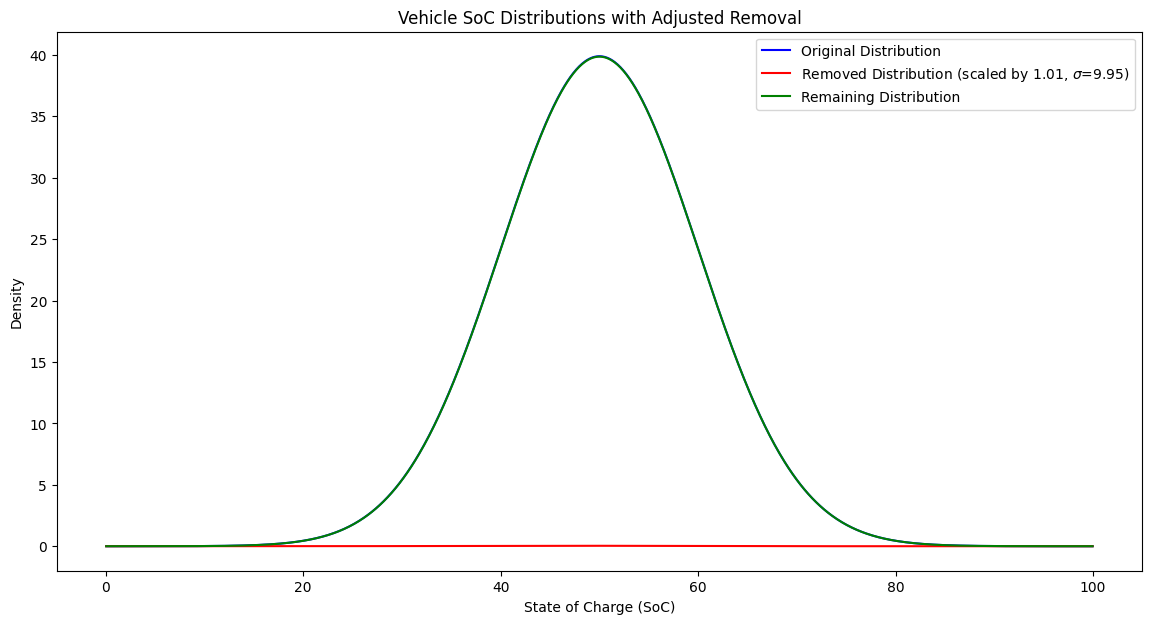

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_vehicle_soc_density(mu_0, sigma, vehicle_count, bins):
    """Generates a continuous density function of vehicle SoC values."""
    bin_centers = (bins[:-1] + bins[1:]) / 2
    density = norm.pdf(bin_centers, mu_0, sigma)
    density *= vehicle_count / density.sum()  # Normalize to total vehicle count
    return density

def find_optimal_removed_params(mu_0, sigma, mu_c, vehicle_count, bins, epsilon=1e-5, max_iter=1000):
    """Finds optimal scaling for removed distribution and adjusts sigma to maintain shape."""
    bin_centers = (bins[:-1] + bins[1:]) / 2
    original_density = generate_vehicle_soc_density(mu_0, sigma, vehicle_count, bins)
    
    # Initial guess for sigma_removed as sigma
    sigma_removed = sigma
    scale_factor = 1  # Start with a scale factor of 1
    
    for _ in range(max_iter):
        removed_density = norm.pdf(bin_centers, mu_c, sigma_removed) * scale_factor
        # Ensure the removed density does not exceed the original density at any point below mu_c
        if np.any(removed_density[bin_centers <= mu_c] > original_density[bin_centers <= mu_c]):
            break  # Stop if the removed density exceeds the original density below mu_c
        scale_factor += epsilon  # Incrementally adjust the scale factor
        
        # Adjust sigma_removed to maintain the shape of the distribution
        sigma_removed = sigma * (scale_factor ** -0.5)
        
    # Calculate the final removed and remaining densities
    removed_density = norm.pdf(bin_centers, mu_c, sigma_removed) * scale_factor
    remaining_density = np.maximum(original_density - removed_density, 0)
    
    return bin_centers, original_density, removed_density, remaining_density, sigma_removed, scale_factor

# Parameters
mu_0, sigma, mu_c, vehicle_count = 50, 10, 45, 10000
bins = np.linspace(0, 100, 1001)

# Run the optimization to find the removed and remaining densities
bin_centers, original_density, removed_density, remaining_density, sigma_removed, scale_factor = find_optimal_removed_params(mu_0, sigma, mu_c, vehicle_count, bins)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(bin_centers, original_density, label='Original Distribution', color='blue')
plt.plot(bin_centers, removed_density, label=f'Removed Distribution (scaled by {scale_factor:.2f}, $\sigma$={sigma_removed:.2f})', color='red')
plt.plot(bin_centers, remaining_density, label='Remaining Distribution', color='green')
plt.title('Vehicle SoC Distributions with Adjusted Removal')
plt.xlabel('State of Charge (SoC)')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import norm

def station_remove_vehicles_gaussian(binned_vehicles, bins, SoC_max, std_dev, max_removals):
    # Calculate the center of each bin and the removal probabilities
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mean = SoC_max * 0.8
    removal_probs = norm.pdf(bin_centers, mean, std_dev)
    removal_probs /= removal_probs.max()  # Normalize probabilities to [0, 1]
    
    # Initially calculate the number of vehicles to remove in each bin
    initial_removed_vehicles = np.random.binomial(binned_vehicles, removal_probs)
    
    # Check if the total removals exceed the maximum allowed
    total_removals = initial_removed_vehicles.sum()
    if total_removals > max_removals:
        # Calculate a scaling factor to ensure total removals do not exceed max_removals
        scaling_factor = max_removals / total_removals
        # Apply the scaling factor uniformly across all bins
        removed_vehicles = np.floor(initial_removed_vehicles * scaling_factor).astype(int)
    else:
        removed_vehicles = initial_removed_vehicles
    
    # Calculate the remaining vehicles after removal
    remaining_vehicles = binned_vehicles - removed_vehicles
    
    return remaining_vehicles, removed_vehicles

# Example usage
SoC_max = 100  # Assuming SoC_max
SoC_res = 5  # Assuming SoC resolution
std_dev = 10  # Standard deviation for the Gaussian distribution
max_removals = 100  # Maximum number of vehicles you want to remove
# Assuming binned vehicle counts (as an example, replace with actual data)
binned_vehicles = np.random.randint(0, 100, size=(SoC_max // SoC_res))
# Define bins according to SoC resolution
bins = np.arange(0, SoC_max + SoC_res, SoC_res)
vehicles_still_charging, vehicles_done_charging = station_remove_vehicles_gaussian(
    binned_vehicles=np.round(binned_vehicles).astype(int), 
    bins=bins, 
    SoC_max=SoC_max, 
    std_dev=10,
    max_removals=max_removals
)

print(vehicles_still_charging)
print(vehicles_done_charging)